In [133]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import scipy.sparse
import scipy.sparse.linalg

## Create test model


In [11]:
# Points
d = {'X': [1, 0, 1, 2, 0, 1, 2, 1], 'Y': [0, 1, 1, 1, 2, 2, 2, 3], 'Name': ['A','B','C','D','E','F','G','H']}

pf = pd.DataFrame(data=d)
pf

,X,Y,Name
0,1,0,A
1,0,1,B
2,1,1,C
3,2,1,D
4,0,2,E
5,1,2,F
6,2,2,G
7,1,3,H


Text(0.5, 1.0, 'points')

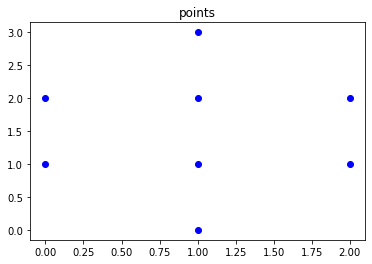

In [12]:
plt.plot(pf.X,pf.Y,'bo')
plt.title('points')

In [14]:
pf.iloc[0,:2]

X    1
Y    0
Name: 0, dtype: object

In [38]:
d = {'Xb': [1, 1, 1, 0, 0, 1, 1, 2, 0, 0, 1, 1, 2], 
     'Yb': [0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2], 
     'Xe': [0, 1, 2, 1, 0, 2, 1, 2, 1, 1, 2, 1, 1], 
     'Ye': [1, 1, 1, 1, 2, 1, 2, 2, 2, 3, 2, 3, 3],
     'Name': ['AB','AC','AD','BC','BE','CD','CF','DG','EF','EH','FG','FH','GH']}
df = pd.DataFrame(data=d)
df

,Xb,Yb,Xe,Ye,Name
0,1,0,0,1,AB
1,1,0,1,1,AC
2,1,0,2,1,AD
3,0,1,1,1,BC
4,0,1,0,2,BE
5,1,1,2,1,CD
6,1,1,1,2,CF
7,2,1,2,2,DG
8,0,2,1,2,EF
9,0,2,1,3,EH


Instead of having a bloated table, I will define here a few functions that could simply create the extra geometric properties of the network on demand.

In [52]:
#Support geometry functions
def section_len(df):
    return np.sqrt((df.Xe-df.Xb)**2+(df.Ye-df.Yb)**2)

def section_angle(df):
    return np.arctan((df.Ye-df.Yb)/(df.Xe-df.Xb))

In [53]:
section_angle(df)

0    -0.785398
1     1.570796
2     0.785398
3     0.000000
4     1.570796
5     0.000000
6     1.570796
7     1.570796
8     0.000000
9     0.785398
10    0.000000
11    1.570796
12   -0.785398
dtype: float64

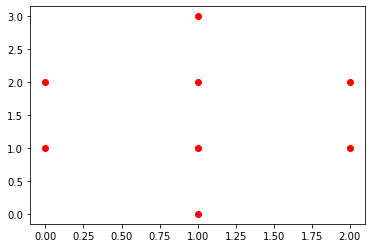

In [29]:
plt.plot(pf.X,pf.Y, 'ro')

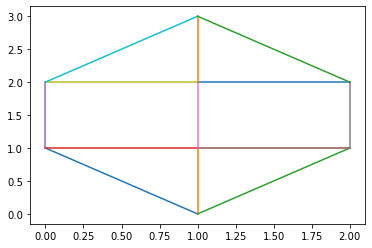

In [96]:
plt.plot([df.Xb,df.Xe],[df.Yb,df.Ye])

Create shorter segments

In [109]:
dx = 0.1
L = section_len(df)
alpha = section_angle(df)
X_len = df.Xe-df.Xb 
Y_len = df.Ye-df.Yb

DFN_Mat2 = np.array([[],[],[],[],[]]).T
for i in range(0,len(df)):
    n_seg = np.floor(L[i]/dx)
    d_seg = L/n_seg

    for j in range(0,int(n_seg)):
        newline0 = df.Xb[i] + j*X_len[i]/n_seg
        newline1 = df.Yb[i] + j*Y_len[i]/n_seg
        newline2 = df.Xb[i] + (j+1)*X_len[i]/n_seg
        newline3 = df.Yb[i] + (j+1)*Y_len[i]/n_seg
        newline4 = df.Name[i]
        
        DFN_Mat2 = np.vstack([DFN_Mat2,[newline0,newline1,newline2,newline3,newline4]])
        

sf = pd.DataFrame(DFN_Mat2, columns = ['Xb','Yb','Xe','Ye','Name'])
sf.iloc[:,0:4] = sf.iloc[:,0:4].astype('float')

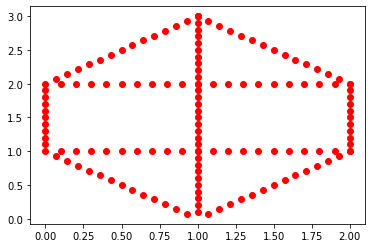

In [110]:
plt.plot(sf.Xe,sf.Ye,'ro')

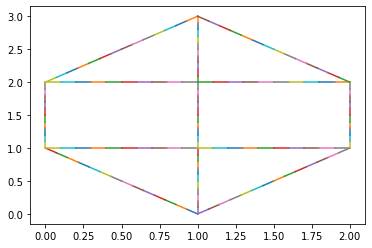

In [111]:
plt.plot([sf.Xb,sf.Xe],[sf.Yb,sf.Ye])

We have to test different discretizations

## Connectivity matrix


The connectivity matrix explains which segment is connected to which other segments.

In [113]:
eps = 0.001
Connect_Mat = np.ones([len(sf),6])*(-999) 


for i in range(0,len(sf)):
        D55 = abs(sf.Xb[:]-sf.Xb[i])
        D66 = abs(sf.Yb[:]-sf.Yb[i])
        D77 = abs(sf.Xe[:]-sf.Xe[i])
        D88 = abs(sf.Ye[:]-sf.Ye[i])
        D57 = abs(sf.Xe[:]-sf.Xb[i])
        D68 = abs(sf.Ye[:]-sf.Yb[i])
        D75 = abs(sf.Xb[:]-sf.Xe[i])
        D86 = abs(sf.Yb[:]-sf.Ye[i])
        
        index = np.where(((D55<=eps) & (D66<=eps)) | ((D77<=eps) & (D88<=eps)) | ((D57<= eps) & (D68<=eps)) | ((D75<=eps) & (D86<=eps)))
        k = 0
        for j in range(0,min(5,len(index[0]))):
            if (index[0][j]!=i):
                Connect_Mat[i,k] = index[0][j]
                k = k+1

In [114]:
Connect_Mat

array([[   1.,   14.,   24., -999., -999., -999.],
       [   0.,    2., -999., -999., -999., -999.],
       [   1.,    3., -999., -999., -999., -999.],
       [   2.,    4., -999., -999., -999., -999.],
       [   3.,    5., -999., -999., -999., -999.],
       [   4.,    6., -999., -999., -999., -999.],
       [   5.,    7., -999., -999., -999., -999.],
       [   6.,    8., -999., -999., -999., -999.],
       [   7.,    9., -999., -999., -999., -999.],
       [   8.,   10., -999., -999., -999., -999.],
       [   9.,   11., -999., -999., -999., -999.],
       [  10.,   12., -999., -999., -999., -999.],
       [  11.,   13., -999., -999., -999., -999.],
       [  12.,   38.,   48., -999., -999., -999.],
       [   0.,   15.,   24., -999., -999., -999.],
       [  14.,   16., -999., -999., -999., -999.],
       [  15.,   17., -999., -999., -999., -999.],
       [  16.,   18., -999., -999., -999., -999.],
       [  17.,   19., -999., -999., -999., -999.],
       [  18.,   20., -999., -9

Geometries are prepared, next come the 


## Physiscs part

Old parameters

In [215]:
#Boundary conditions (pressure for now)
BC_coord = np.array(((-1,1,0),(1,1,3)))

P_Inj = 3e5     # Injection pressure [Pa]
P_Prod = 1e5    # Production pressure [Pa]
P_ini = 2e5     # Initial pressure in the fractures [Pa]


# +++++++++++++++ these need to be adjusted:
Dt_P = 0.001      # Pressure time step for steady state [sec]
DP_time = 0.05
n_time_P = int(DP_time/Dt_P) # Maximum number of pressure time steps

num_Frac = len(sf)

AP = np.zeros([num_Frac,num_Frac])  # Init pressure conductivity Matrix(LHS)
BP = np.zeros(num_Frac)# Init pressure storativity Vector (RHS)



#Solve for steady-state pressure
tp = -1
#timeP = np.linspace(Dt_P,DP_time,n_time_P)

#P_new = [0]*num_Frac
BP = np.zeros(num_Frac)
APl = np.copy(AP)   #Local variable


Hydraulic parameters

These need to be adjusted for the surface water flow

In [216]:
Gamma_P = np.zeros(num_Frac)
Gamma_P_tot = np.zeros(num_Frac)
Etha_P = np.zeros(num_Frac)

for i in range(0,num_Frac):
        Gamma_P[i] = .1   # Transmissivity 1
        Etha_P[i] = .1                 # Storativity 1

In [217]:
for i in range(0,num_Frac):
    Gamma_P_tot[i] = Gamma_P[i]
    for j in range(0,6):
        cn = int(Connect_Mat[i,j])
        if (cn >= 0):
            Gamma_P_tot[i] = Gamma_P_tot[i] + Gamma_P[cn]   # if and g1g2 based on index
            AP[i,cn] = Gamma_P[i]*Gamma_P[cn]
            AP[i,i] = AP[i,i]-Gamma_P[i]*Gamma_P[cn]
    AP[i,i] = AP[i,i]/Gamma_P_tot[i] - Etha_P[i]
    for j in range(0,6):
        cn = int(Connect_Mat[i,j])
        if (cn >= 0):
            AP[i,cn] = AP[i,cn]/Gamma_P_tot[i]

In [218]:
AP

array([[-0.175     ,  0.025     ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.03333333, -0.16666667,  0.03333333, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.03333333, -0.16666667, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ..., -0.16666667,
         0.03333333,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.03333333,
        -0.16666667,  0.03333333],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.025     , -0.175     ]])

In [243]:
 # Solve Finite Difference pressure
P_old = np.ones(num_Frac)
P_new = np.zeros([n_time_P,num_Frac])    

tp = -1
while (tp < n_time_P-1):
    tp = tp + 1

    #Apply initial conditions
    if (tp==0):
        P_old = P_old*P_ini     # Initial pressure
    else:
        P_old[0:num_Frac] = P_new[tp-1,:]

#            for i in range(0,num_Frac):
#                BP[i] = -Etha_P[i]*P_old[i]
    BP = -Etha_P*P_old

    # Apply boundary conditions
    APl[0,:] = 0
    APl[0,0] = 1
    BP[0] = P_Inj
    
    APl[len(sf)-1,:] = 0
    APl[len(sf)-1,len(sf)-1] = 1
    BP[len(sf)-1] = P_Prod
    
    # Injection points
    #APl[int(Inj_id[idinj]),:] = 0
    #APl[int(Inj_id[idinj]),int(Inj_id[idinj])] = 1
    #BP[int(Inj_id[idinj])] = P_Inj
    
    #Production points
#        for i in range(0,np.shape(Prod_id)[0]):
#            APl[int(Prod_id[i]),:] = 0
#            APl[int(Prod_id[i]),int(Prod_id[i])] = 1
#            BP[int(Prod_id[i])] = P_Prod

    # Solver for pressure
    #AP2 =  #SPARSE MATRIX NEEDED for performance
    AP2 = scipy.sparse.csc_matrix(APl)

    P_new[tp,:] = scipy.linalg.solve(AP,BP.T) #standard solution
    #P_new[tp,:] = scipy.sparse.linalg.spsolve(AP2,BP.T,permc_spec='MMD_ATA') #Fastest but can be singular
    #P_new[tp,:] = scipy.linalg.lstsq(AP,BP.T)[0] #numerical approx
    
tss = tp

P_new = P_new[0:tss+1,:]

C

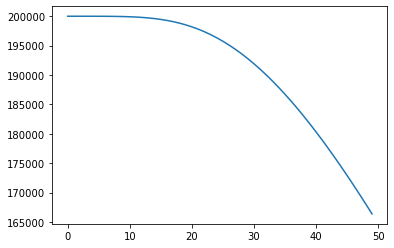

In [245]:
plt.plot(P_new[:,100])

Calculate velocities next
(I am not sure if this is going to be needed in the end)

In [248]:
    #Estimate velocity
    num_up = np.zeros(num_Frac)
    V = np.zeros(num_Frac)
    for i in range(0,num_Frac):
        P_Max = P_new[tss,i]
        num_up[i] = i
        for j in range(0,6):
            cn = int(Connect_Mat[i,j])
            if (cn >= 0 and P_new[tp,cn] > P_Max):
                P_Max = P_new[tp,cn]
                num_up[i] = cn
        
            V[i] = 1**2/(12*1*2)*(P_Max-P_new[tp,i])


Plotting out velocity distribution

In [250]:
import matplotlib

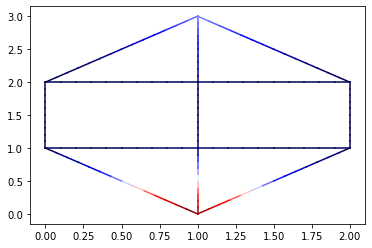

In [256]:
V_norm = (V-min(V))/(max(V)-min(V))
cmap = matplotlib.cm.get_cmap('seismic')

for i in range(0,len(sf)):
    plt.plot([sf.Xb[i],sf.Xe[i]],[sf.Yb[i],sf.Ye[i]],color=cmap(V_norm[i]))
    
#plt.plot([sf.Xb,sf.Xe],[sf.Yb,sf.Ye],color=cmap(V_norm))
    

In [253]:
cmap(1)

(0.0, 0.0, 0.31098039215686274, 1.0)